In [1]:
"""Scripts for analyzing of phantom outputs.

This script generate lightcurves (LC) by doing radiative transfer on a grid.

"""

'Scripts for analyzing of phantom outputs.\n\nThis script generate lightcurves (LC) by doing radiative transfer on a grid.\n\n'

# Main

## Imports & Settings

In [2]:
import numpy as np
from numpy import pi
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit
import sarracen
from scipy import integrate
#from moviepy.editor import ImageSequenceClip
#from os import path

/home/clmu/anaconda3/envs/clmu_1/lib/python3.11/site-packages/sarracen/kernels/cubic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1/lib/python3.11/site-packages/sarracen/kernels/quartic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1

In [3]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
from clmuphantomlib            import MyPhantomDataFrames, get_eos
from clmuphantomlib.log        import is_verbose, say
from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit #set_as_quantity, get_units_field_name, get_units_cgs
from clmuphantomlib.readwrite  import json_dump, json_load
from clmuphantomlib.eos_mesa   import EoS_MESA_opacity
from clmuphantomlib.light      import get_optical_depth_by_ray_tracing_3D, get_photosphere_on_ray

from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

/mnt/d/Sync_OneDrive/Macquarie University/Project RT in CEE - Docs/Projects/20230201/src/clmuphantomlib/sph_interp.py:36: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False)
/mnt/d/Sync_OneDrive/Macquarie University/Project RT in CEE - Docs/Projects/20230201/src/clmuphantomlib/sph_interp.py:49: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(

In [5]:
# settings
#
#   imported from script_input.py file


from script_LCGen__input import verbose, interm_dir, output_dir, unitsOut, PHOTOSPHERE_TAU, JOB_PROFILES_DICT
from _sharedFuncs import mpdf_read

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


# set metadata
with open("_metadata__input.json", 'r') as f:
    metadata = json_load(f)
metadata['Title'] = "Getting light curves by intergrating across a grid of rays"
metadata['Description'] = f"""Getting light curves by intergrating across a grid of rays with the same directions
for dump file data generated by phantom
"""


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 8 processes for parallelization


### Note- old codes below, need to double check if these are fine

In [113]:
@jit(nopython=False)
def integrate_along_ray(
    sdf, ray, srcfuncs, photosphere_tau=1.,
    verbose: int = 3,
):
    pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf=sdf, ray=ray)
    if is_verbose(verbose, 'debug'):
        say('debug', 'integrate_along_ray()', verbose, 'optical depth got.')

    dtaus_ordered = dtaus[pts_order]
    if is_verbose(verbose, 'debug'):
        say('debug', 'integrate_along_ray()', verbose, 'ordered.')
    srcfuncs_ordered = srcfuncs[pts_order]
    if is_verbose(verbose, 'debug'):
        say('debug', 'integrate_along_ray()', verbose, 'srcfuncs_ordered.')
    dat_steps = np.full_like(dtaus_ordered, np.nan)

    if True:
    #if backwards:
        # closest to observer to furtherest
        dat = 0.
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])
        # dat_bwd_inc: dat_backward_contributions
        dat_bwd_inc = np.exp(-taus_ordered) * (1 - np.exp(-dtaus_ordered)) * srcfuncs_ordered
        dat = np.sum(dat_bwd_inc)
        if is_verbose(verbose, 'info'):
            say('info', 'integrate_along_ray()', verbose,
                f"backward dat = {dat}")    # debug
        if False:
            # commented
            # get the percentage of contribution to lum from photosphere outwards
            photosphere_loc_index = np.searchsorted(taus_ordered, photosphere_tau) - 1
            photosphere_contri_percent = np.sum(dat_bwd_inc[:photosphere_loc_index+2]) / dat * 100
            dat_percent_index = np.where(np.cumsum(dat_bwd_inc) / dat<0.5)[0][-1]
            if is_verbose(verbose, 'info'):
                say('info', 'integrate_along_ray()', verbose,
                    f"\tContribution to L from photosphere and outwards is: {photosphere_contri_percent} %",
                    f"\t50% Contributed correspond to tau = {taus_ordered[dat_percent_index]} ")
        taus_ordered = taus_ordered[::-1]

    else:
        # furtherest to observer to closest
        dat = 0.
        #  pts_order[::-1]: reverse pts_order so that the furtherest particles comes first
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])[::-1]
        exp_mdtaus_r = np.exp(-dtaus_ordered[::-1])
        srcfuncs_ordered_r = srcfuncs_ordered[::-1]
        for index, srcfunc in enumerate(srcfuncs_ordered_r):
            exp_mdtau = exp_mdtaus_r[index]
            dat = exp_mdtau * dat + (1-exp_mdtau) * srcfunc
            dat_steps[index] = dat
        if is_verbose(verbose, 'info'):
            say('info', 'integrate_along_ray()', verbose,
                f"forward dat = {dat}")    # debug
        
    dtaus_ordered = dtaus_ordered[::-1]
    pts_order = pts_order[::-1]  # furtherest to observer to closest
    pts_on_ray_ordered = pts_on_ray[pts_order]
    
    
    return  pts_order, pts_on_ray, dtaus_ordered, taus_ordered, \
            dat, dat_steps, dat_bwd_inc

In [7]:
@jit(nopython=False)
def integrate_error_along_ray(
    dtaus_ordered, # furtherest to closest
    srcfuncs_ordered, srcfuncs_ordered_errp, srcfuncs_ordered_errm,
    photosphere_tau=1.,
):
    #if backwards:
    if True:
        
        # closest to observer to furtherest
        dtaus_ordered = dtaus_ordered[::-1]
        
        # calc data + error
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])
        srcfuncs_errs = np.stack([srcfuncs_ordered, srcfuncs_ordered_errp, srcfuncs_ordered_errm])
        srcfuncs_errs = np.flip(srcfuncs_errs, axis=-1) # flip it since we are working backwards
        dat_bwd_inc_errs = np.exp(-taus_ordered) * (1 - np.exp(-dtaus_ordered)) * srcfuncs_errs
        dat_errs = np.sum(dat_bwd_inc_errs, axis=-1)
        
        dat_bwd_inc_errs = np.flip(dat_bwd_inc_errs, axis=-1)
        
        if False:
            # get data
            dat_bwd_inc = dat_bwd_inc_errs[0]
            dat = dat_errs[0]
            dat_errp = dat_errs[1]
            dat_errm = dat_errs[2]
        

    else:
        raise NotImplementedError()
        # furtherest to observer to closest
        dat = 0.
        dat_steps = np.full_like(dtaus_ordered, np.nan)
        #  pts_order[::-1]: reverse pts_order so that the furtherest particles comes first
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])[::-1]
        exp_mdtaus_r = np.exp(-dtaus_ordered[::-1])
        srcfuncs_ordered_r = srcfuncs_ordered[::-1]
        for index, srcfunc in enumerate(srcfuncs_ordered_r):
            exp_mdtau = exp_mdtaus_r[index]
            dat = exp_mdtau * dat + (1-exp_mdtau) * srcfunc
            dat_steps[index] = dat
        print("forward dat = ", dat)    # debug
        
    #dtaus_ordered = dtaus_ordered[::-1]
    return dat_errs, dat_bwd_inc_errs

    # code bkp
    def get_xy_grids_of_rays(
        sdf  : None|sarracen.SarracenDataFrame = None,
        dxs  : None|tuple[float, float]= (None, None),
        no_xy: tuple[int, int] = (32+1, 32+1),
        orig_vec: np.ndarray = np.zeros(3),
        frac_contained: float = 99.73,
        verbose: int = 3,
    ) -> tuple[np.ndarray, np.ndarray]:
        """Get a grid of rays.
    
        Supply either sdf or both dx and dy.
        
        Parameters
        ----------
        sdf: sarracen.SarracenDataFrame
        
        dx, dy: float
            width of the grid cells. in sdf units['dist'].
    
        no_x, no_y: int
            number of the rays per axes.
    
        orig_vec: (3,)-shaped np.ndarray
            Vector defining the origin point of the grid.
            
        frac_contained : float
            Suggested percentage of the particle that are contained within the grid
    
    
        Returns: rays, areas
        -------
        rays: (no_ray, 2, 3)-shaped np.ndarray
    
        areas: (no_ray)-shaped np.ndarray
            areas corresponding to each ray in the grid
            
        """
    
        unit_vec = np.array([0., 0., 1.])
        
        # get dx & dy
        frac_contained_m = 50. - frac_contained / 2.
        frac_contained_p = 50. + frac_contained / 2.
        if dxs is None or dxs[0] is None or dxs[1] is None:
            dxs = [
                dxs[i] if dxs is not None and dxs[i] is not None else max(
                    abs(np.percentile(sdf[label] + sdf['h'], frac_contained_p)),
                    abs(np.percentile(sdf[label] - sdf['h'], frac_contained_m)),
                ) * 2. / (no_xy[i]-1)
                for i, label in enumerate(['x', 'y'])
            ]
        if is_verbose(verbose, 'info'):
            say('info', 'get_xy_grids_of_rays()', verbose, f"dx, dy = {dxs}")
    
        x0, y0, z0 = orig_vec
        xys = [np.linspace(
            i0 - di * (no_i-1) / 2.,
            i0 + di * (no_i-1) / 2.,
            no_i,
        ) for i0, di, no_i in zip([x0, y0], dxs, no_xy)]
        # Note: orig_vecs must be 2D (i.e. in shape of (no_ray, 3))
        orig_vecs = np.array([[x, y, z0] for y in xys[1] for x in xys[0]])
        #orig_vecs = [[[x, y, z0] for x, y in zip(xs, ys)] for xs, ys in zip(*np.meshgrid(*xys))]
        areas = (dxs[0] * dxs[1]) * np.ones(orig_vecs.shape[0])
    
        rays = mupl.geometry.get_rays(orig_vecs=orig_vecs, unit_vecs=unit_vec)
        
        return rays, areas

In [8]:
def get_xy_grids_of_rays(
    sdf  : None|sarracen.SarracenDataFrame = None,
    #dXs  : None|list[list[float], list[float]]|np.ndarray= None,
    no_xy: tuple[int, int] = (32, 32),
    #orig_vec: np.ndarray = np.zeros(3),
    frac_contained: float = 100., #99.73,
    use_adaptive_grid: bool = False,
    verbose: int = 3,
) -> tuple[np.ndarray, np.ndarray, list[np.ndarray]]:
    """Get a grid of rays (must pointing at z direction for now).

    Supply either sdf or both dx and dy.
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame

    no_xy: tuple[int, int]
        number of the rays per axes.
        
    frac_contained : float
        Suggested percentage of the particle that are contained within the grid. in (0, 100]

    use_adaptive_grid : bool
        if True,
            will scale dXs according to particle distribution instead of even intervals,
            if dXs is None or (None, None).


    Returns: rays, areas, dXs
    -------
    rays: (no_ray, 2, 3)-shaped np.ndarray

    areas: (no_ray)-shaped np.ndarray
        areas corresponding to each ray in the grid
        
    dXs: list of no_xy[i]-shaped np.ndarray
        width of the grid cells. in sdf units['dist'].
        
    """

    unit_vec = np.array([0., 0., 1.])
    #x0, y0, z0 = orig_vec
    z0 = 0.    # z value for rays
    
    # get dx & dy
    frac_contained_m = 50. - frac_contained / 2.
    frac_contained_p = 50. + frac_contained / 2.

    Xs_edges = []
    for i, label in enumerate(['x', 'y']):
        #i0 = orig_vec[i]
        if use_adaptive_grid:
            # fraction points for the adaptive grid
            fracs = np.linspace(frac_contained_m, frac_contained_p, no_xy[i]+1)
            # edge points for the grid
            Xs_edges.append(
                np.percentile(np.concatenate((sdf[label] - sdf['h'], sdf[label] + sdf['h'])), fracs))
        else:
            Xs_edges.append(
                np.linspace(
                    *np.percentile(np.concatenate(
                        (sdf[label] - sdf['h'], sdf[label] + sdf['h'])), (frac_contained_m, frac_contained_p)),
                    no_xy[i]+1
                )
            )

    dXs = [np.diff(Xi_edges) for Xi_edges in Xs_edges]    # each item is (no_xy[i]+1,)-shaped
    Xs_centers = [Xi_edges[:-1] + dXi/2. for dXi, Xi_edges in zip(dXs, Xs_edges)]    # each item is (no_xy[i],)-shaped

    # Note: orig_vecs must be 2D (i.e. in shape of (no_ray, 3))
    orig_vecs = np.array([[x, y, z0] for y in Xs_centers[1] for x in Xs_centers[0]])
    #orig_vecs = [[[x, y, z0] for x, y in zip(xs, ys)] for xs, ys in zip(*np.meshgrid(*xys))]
    areas = np.array([dx*dy for dy in dXs[1] for dx in dXs[0]])

    rays = mupl.geometry.get_rays(orig_vecs=orig_vecs, unit_vecs=unit_vec)
    
    return rays, areas, dXs

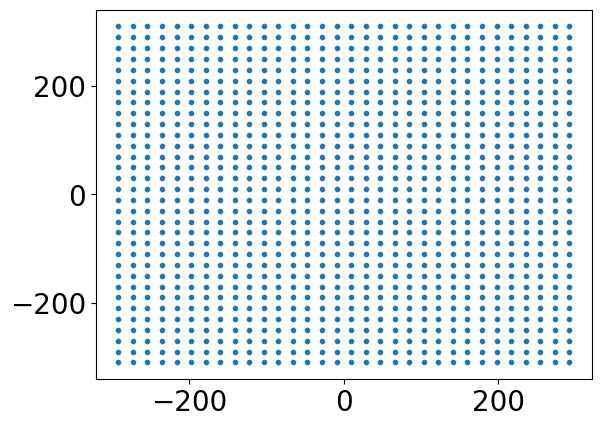

In [226]:
# testing ray loc distribution
rays, areas, dXs = get_xy_grids_of_rays(sdf, no_xy=(32, 32), frac_contained=100., use_adaptive_grid=False)
plt.plot(rays[:, 0, 0], rays[:, 0, 1], '.')

In [198]:
dXs[1].shape

(17,)

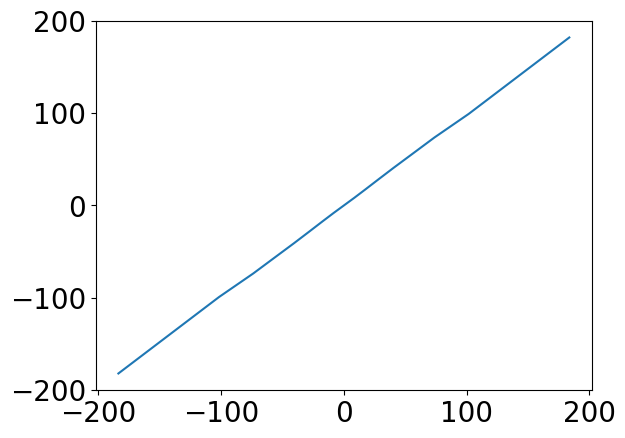

In [154]:
plt.hist(*Xs_centers)

### In Writing

#### Getting LC

In [66]:
do_extrap: bool = False
T_cond_oxy: units.Quantity = 1450 * units.K
kappa_gas : units.Quantity = 2e-4*(units.cm**2/units.g)
job_name    = '../dustystar/clmu_dustybase/relax'#job_profile['job_name']
file_index  = 0
params      = JOB_PROFILES_DICT['2md']['params'] #job_profile['params']


mpdf.read(job_name, file_index, reset_xyz_by='CoM', calc_params=['vr', 'R1'], verbose=verbose)
sdf  = mpdf.data['gas']
eos = mupl.get_eos(ieos=10, params=params, settings=settings)
eos_opacity = EoS_MESA_opacity(params, settings)
sdf['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
del sdf['Tdust']
kappa_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=do_extrap)
#mpdf.data['gas']['kappa'] = np.where(
#    mpdf.data['gas']['T'] < T_cond_oxy,
#    kappa_gas.to_value( mpdf.units['opacity']),
#    kappa_mesa.to_value(mpdf.units['opacity']),
#)
mpdf.data['gas']['kappa'] = kappa_mesa.to_value(mpdf.units['opacity'])

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../dustystar/clmu_dustybase/relax_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([-3.80369850e-16  3.71216564e-17 -6.51535922e-19])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [-2.44519036e-16  2.48560465e-17 -4.36257665e-19]


In [22]:
#no_xy=(17, 17)
no_xy=(32, 32)
srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) #/ (4 * pi)

rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
lum = 0.
lums = []
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lums.append(dat*area)
    if i%50 == 0:
        print(i)
    i += 1

lums = (lums*mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
7.77e+03 solLum


<Quantity 7765.91938062 solLum>

(array([ 118.,  296., 3210., 3684., 1236.,  842.,  346.,  124.,  100.,
          44.]),
 array([3.33697822, 3.60437679, 3.87177536, 4.13917393, 4.4065725 ,
        4.67397107, 4.94136964, 5.20876821, 5.47616678, 5.74356535,
        6.01096392]),
 <BarContainer object of 10 artists>)

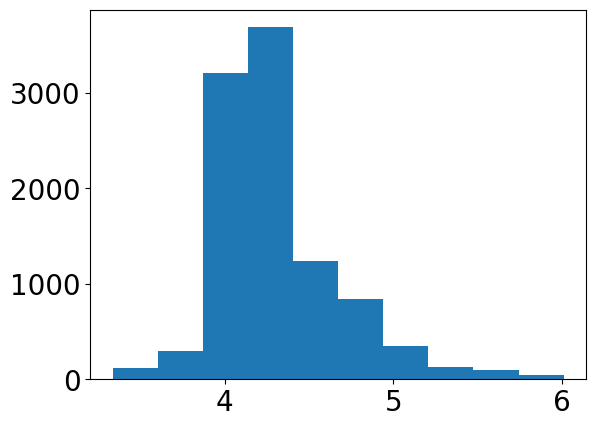

In [367]:
plt.hist(np.log10(mpdf.get_val('T').value))

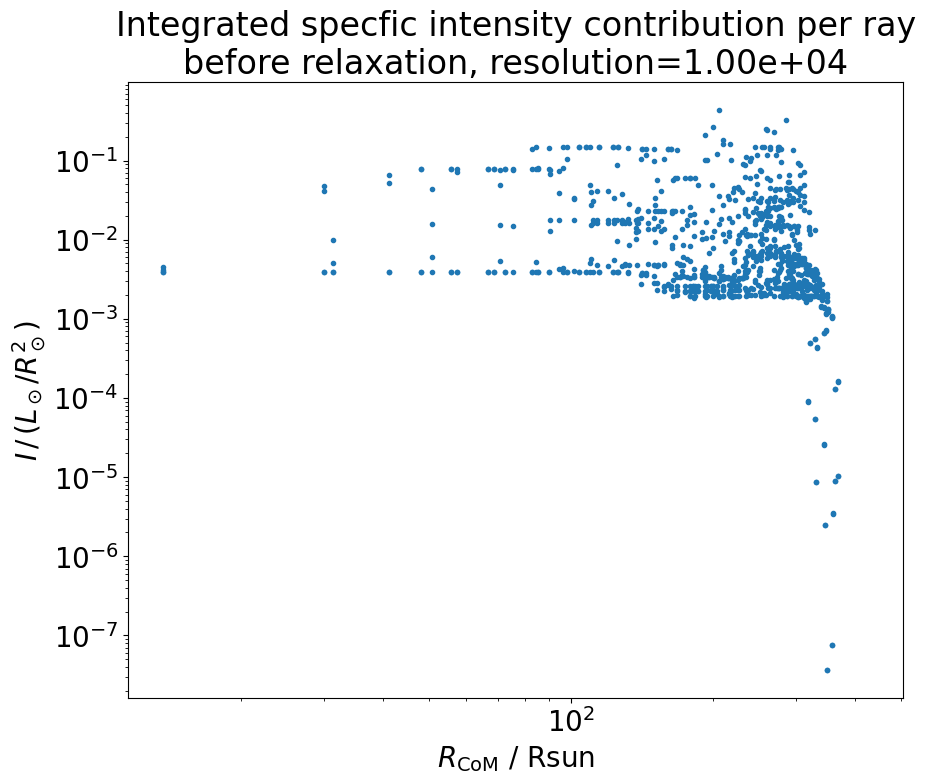

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.to_value(units.Lsun) / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
#ax.set_ylabel('$\\triangle L$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_relax_res{mpdf.params['nparttot']:.2e}.png")

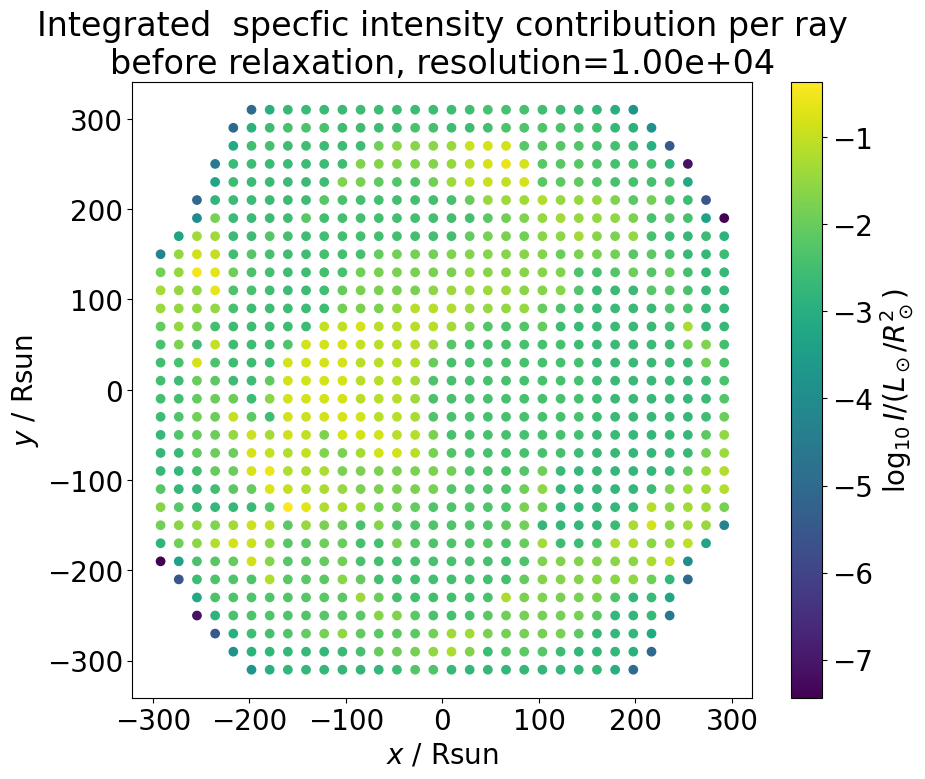

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=np.log10(np.array(lums / areas).reshape(no_xy)))
fig.colorbar(s, label='$\\log_{10} {I / (4 \pi L_\\odot / R_\\odot^2)}$')
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Rsun')
ax.set_title(f"Integrated  specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dlum_relax_res{mpdf.params['nparttot']:.2e}.png")

.

#### Trying the same thing with after-relaxed higher resolution model

.

In [127]:
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 17600, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
print(f"{mpdf.get_time() = }")

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_17600'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to R1 ([-345.05015928  227.08037869 -867.12351873])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 339.78660147 -213.69682275  860.39548887]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
    Note: Density column rho already exist in self.time = 880000.0.
mpdf.get_time() = <Quantity 44.44143789 yr>


In [90]:
mpdf.data['gas']['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
mpdf.data['gas'][['Tdust', 'temperature', 'T']]

,Tdust,temperature,T
0,460.434421,460.434421,460.342020
1,717.911009,717.911009,717.758565
2,633.915089,633.915089,633.792555
3,553.322153,553.322153,553.366728
4,482.393791,482.393791,482.272849
...,...,...,...
1372083,650.661781,650.661781,650.894634
1372084,717.535743,717.535743,717.609236
1372085,678.583507,678.583507,678.819719
1372086,572.627562,572.627562,572.711832


In [119]:
#no_xy=(17, 17)
no_xy=(32, 32)
srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) #/ (4 * pi)

rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
lum = 0.
lums = []
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lums.append(dat*area)
    if i%50 == 0:
        print(i)
    i += 1

lums = (lums*mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
4.06e+04 solLum


<Quantity 40560.81844427 solLum>

In [130]:
#no_xy=(17, 17)
no_xy=(12, 12)
srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) #/ (4 * pi)

rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
lum = 0.
lums = []
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lums.append(dat*area)
    if i%50 == 0:
        print(i)
    i += 1

lums = (lums*mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

0
50
100
4.09e+04 solLum


<Quantity 40892.56239475 solLum>

(array([2.40000e+01, 2.23000e+02, 5.48000e+02, 9.53000e+02, 1.33700e+03,
        2.91300e+03, 3.12730e+04, 9.32070e+04, 4.74667e+05, 7.47021e+05]),
 array([0.98836105, 1.18881371, 1.38926636, 1.58971901, 1.79017167,
        1.99062432, 2.19107697, 2.39152963, 2.59198228, 2.79243493,
        2.99288759]),
 <BarContainer object of 10 artists>)

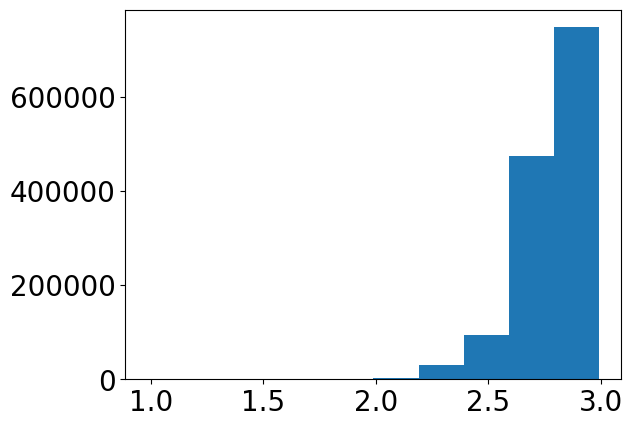

In [120]:
plt.hist(np.log10(mpdf.get_val('T').value))

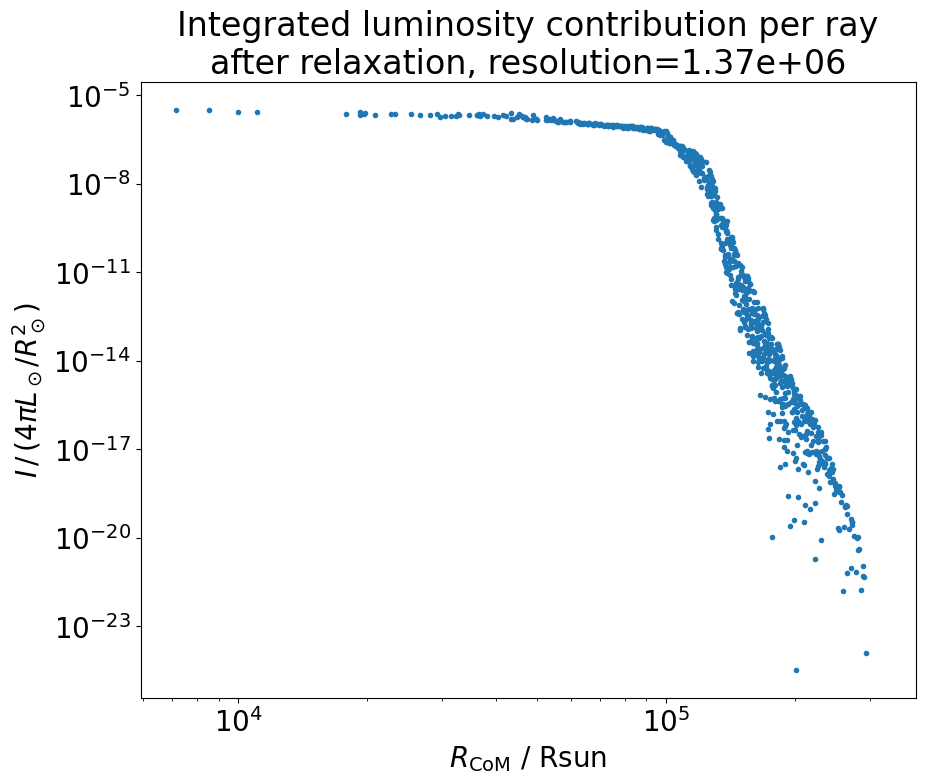

In [121]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.to_value(units.Lsun) / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
ax.set_title(f"Integrated luminosity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_light_res{mpdf.params['nparttot']:.2e}.png")

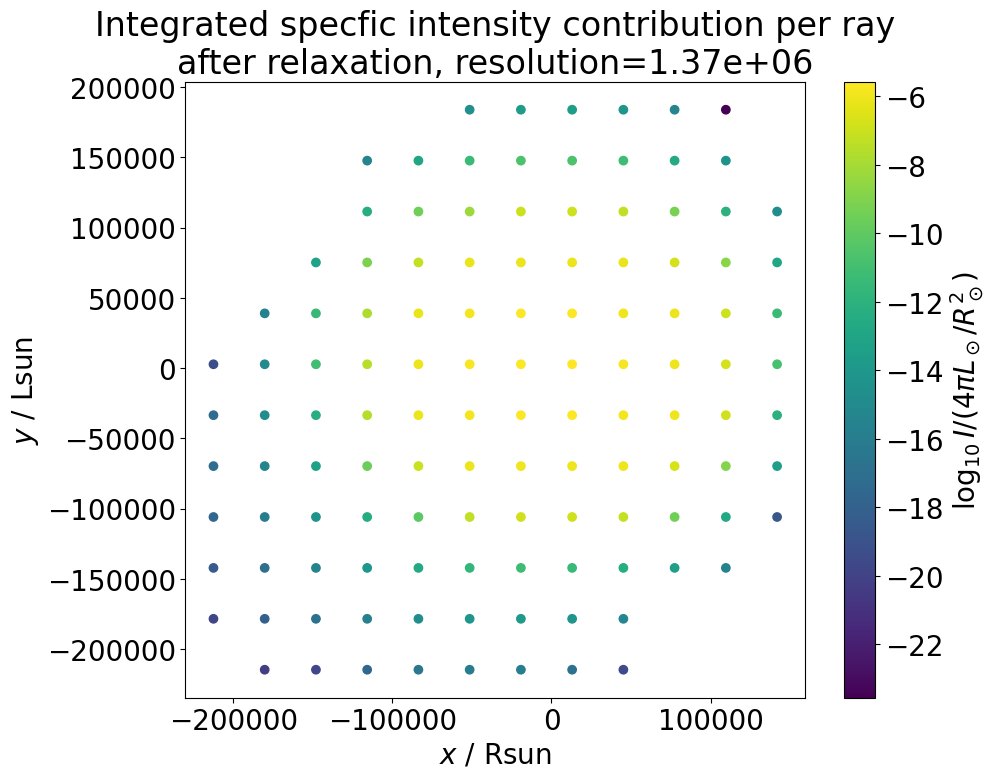

In [131]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=np.log10(np.array(lums / areas).reshape(no_xy)))
fig.colorbar(s, label='$\\log_{10} {I / (4 \pi L_\\odot / R_\\odot^2)}$')
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dI_light_res{mpdf.params['nparttot']:.2e}.png")

'4.56e+07 solLum'

In [ ]:
f"{lum:.2e}"

In [83]:
get_xy_grids_of_rays

<function __main__.get_xy_grids_of_rays(sdf: None | sarracen.sarracen_dataframe.SarracenDataFrame = None, dxs: None | tuple[float, float] = (None, None), no_xy: tuple[int, int] = (33, 33), orig_vec: numpy.ndarray = array([0., 0., 0.]), frac_contained: float = 99.73, verbose: int = 3) -> tuple[numpy.ndarray, numpy.ndarray]>

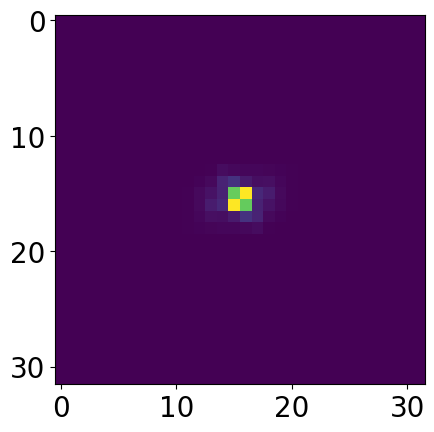

In [232]:
plt.imshow(np.array(lums).reshape(no_xy))

In [15]:
mpdf.data['gas']['u']

0       0.003596
1       0.003596
2       0.012142
3       0.012142
4       0.004077
          ...   
9995    0.003971
9996    0.004889
9997    0.004889
9998    0.008964
9999    0.008964
Name: u, Length: 10000, dtype: float64

## IGNORE BELOW
#### NOT YET FINISHED ADAPTING FROM THE OLD SCRIPTS

### Getting initial MESA profile vs relaxed phantom profile

In [49]:
def plot_stuff(stuff_dict: dict, x_name: str, y_name: str, mpdf, job_profile, xlim: tuple[float, float]=(1., 1e3)):
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.loglog(stuff_dict[x_name], stuff_dict[y_name], '.')
    ax.set_xlabel(f"{x_name} / {stuff_dict[x_name].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"{y_name} / {stuff_dict[y_name].unit.to_string('latex_inline')}")
    ax.text(
        0.98, 0.98, f"Time = {mpdf.get_time()}",
        ha = 'right', va = 'top', transform=ax.transAxes,
    )
    ax.set_title(f"scatter plot of all particles\n{job_profile['plot_title_suffix']}")
    ax.set_xlim(xlim)
    return fig, ax

In [8]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 #/ (4 * pi)

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to R1 ([-1.43135206e+02  6.48807731e-03  5.43625638e-03])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 1.43135206e+02 -6.48807731e-03 -5.43625638e-03]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
    Note: Density column rho already exist in self.time = 0.0.


In [51]:
# reading mesa data
mesa_data = np.loadtxt(
    '../dustystar/AGB_th.data', skiprows=6,
    usecols=(2, 3, 4, 9, 10, 11, 12, 19),
    dtype=[
        ('log10_R1', np.double),
        ('log10_T', np.double),
        ('log10_rho', np.double),
        ('R1_cm', np.double),
        ('mass_g', np.double),
        ('temp', np.double),
        ('rho', np.double),
        ('lum', np.double)]
)
stuff_mesa = {
    'R1': (mesa_data['R1_cm'] * units.cm).to(units.Rsun),
    'T' : mesa_data['temp'] * units.K,
    'lum' : mesa_data['lum'] * units.Lsun,
    'rho' : mesa_data['rho'] * (units.g/units.cm**3)
}
del mesa_data 
stuff_mesa['L'    ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T']**4)).to(units.Lsun)
stuff_mesa['kappa'] = eos_opacity.get_kappa(rho=stuff_mesa['rho'], T=stuff_mesa['T'])
#stuff_mesa['wtf'  ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T'].value**2.5 * units.K**4)).to(units.Lsun)
# below should be one, but it is not. Not sure why
L_0 = stuff_mesa['lum'][0]
R_0 = stuff_mesa[ 'R1'][0]
stuff_mesa['factor'] = (stuff_mesa['R1'].cgs**2 * (
    R_0**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs
stuff_mesa['wtf'  ]  = (integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2)[::-1].cgs, stuff_mesa['R1'][::-1].cgs, initial=0
    )*units.cm**(-2))[::-1]
stuff_mesa['test' ]  = (stuff_mesa['R1'].cgs[0]**2 * (
    stuff_mesa['R1'].cgs**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs

In [67]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['rho'  ] = mpdf.get_val('rho').cgs

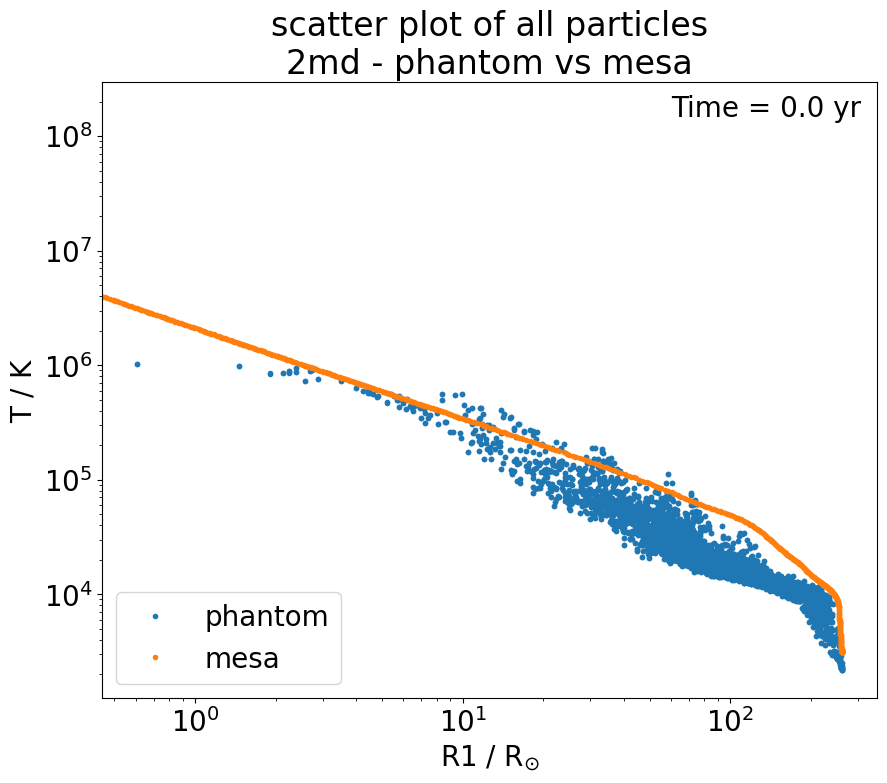

In [68]:
fig, ax = plot_stuff(stuff, 'R1', 'T', mpdf, {'plot_title_suffix' : job_nickname + " - phantom vs mesa"}, xlim=None)
ax.loglog(stuff_mesa['R1'], stuff_mesa['T'], '.', label='mesa')
ax.legend(['phantom', 'mesa'], loc='lower left')
fig.savefig(f"{output_dir}/temp.png")

In [79]:
np.log(678e89)

211.44922056441047

In [88]:
%timeit np.log(123e34) - 211.44922056441047

645 ns ± 29 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [85]:
%timeit 123e34 / np.exp(211.44922056441047)

646 ns ± 44.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [10]:
(450*units.au).to_value(mpdf.units['dist'])

96729.71020188232

In [20]:
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

<Quantity 0.09406566 solMass>

In [ ]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

In [10]:
mpdf.get_val('kappa').cgs

<Quantity [133.56917133, 133.57835947,  30.65612505, ..., 123.5633288 ,
           145.02782696, 145.43255533] cm2 / g>

In [9]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['wtf'  ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T'].value**2.5 * units.K**4)).to(units.Lsun)
stuff['rhokappa'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs
stuff['rhokappaR'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs * mpdf.get_val('R1').cgs

In [12]:
np.max(stuff['rhokappaR'] / (stuff['rhokappaR'] - 2) - 1)

<Quantity 5.93546797>

In [13]:
np.min(stuff['rhokappaR'] )

<Quantity 1.14535854>

In [94]:
(stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs

<Quantity [7.36338304e-39, 7.36338305e-39, 7.36338311e-39, ...,
           1.93680116e-10, 2.86581724e-10, 4.54900567e-10] 1 / cm3>

In [83]:
(L_0 / R_0**2).cgs

<Quantity 6.85653849e+10 g / s3>

(0.0, 2.0)

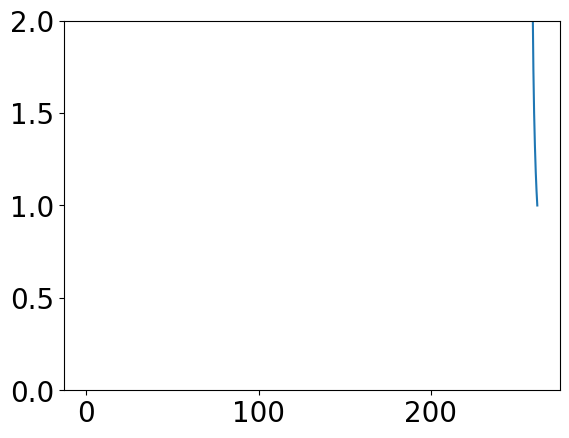

In [96]:
plt.plot(stuff_mesa['R1'], stuff_mesa['factor'])
plt.ylim(0., 2.)

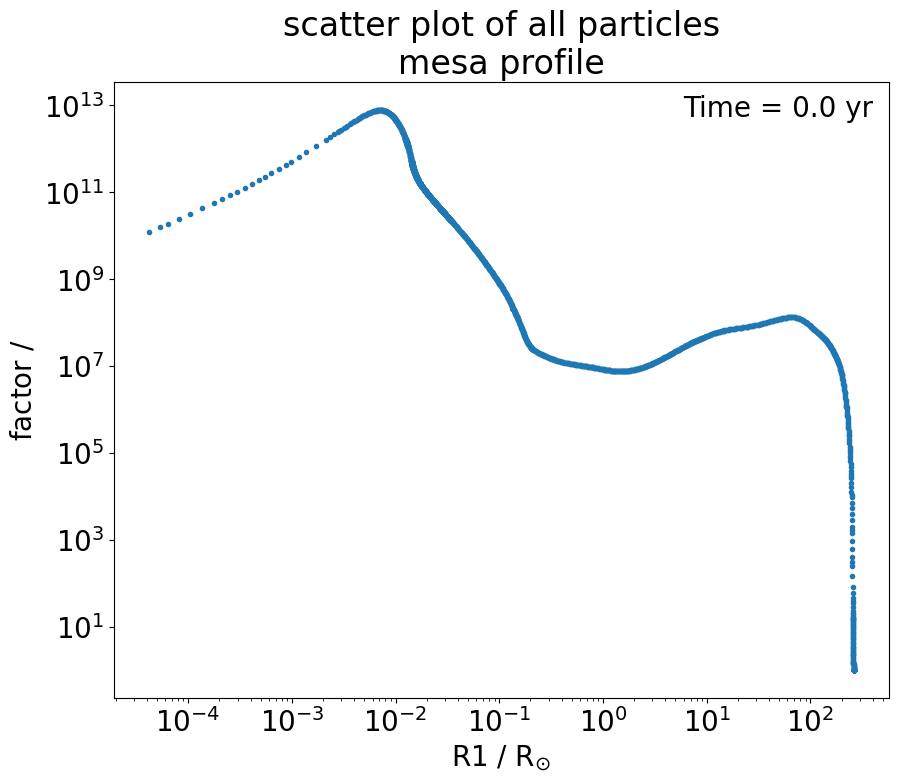

In [102]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'factor', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

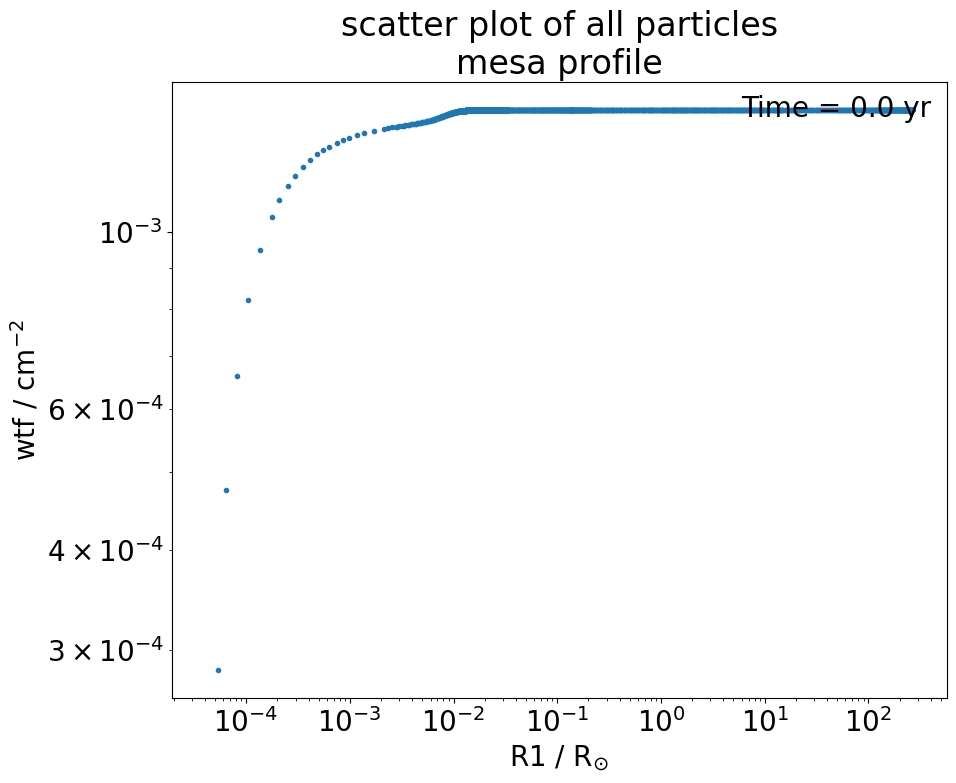

In [77]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'wtf', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

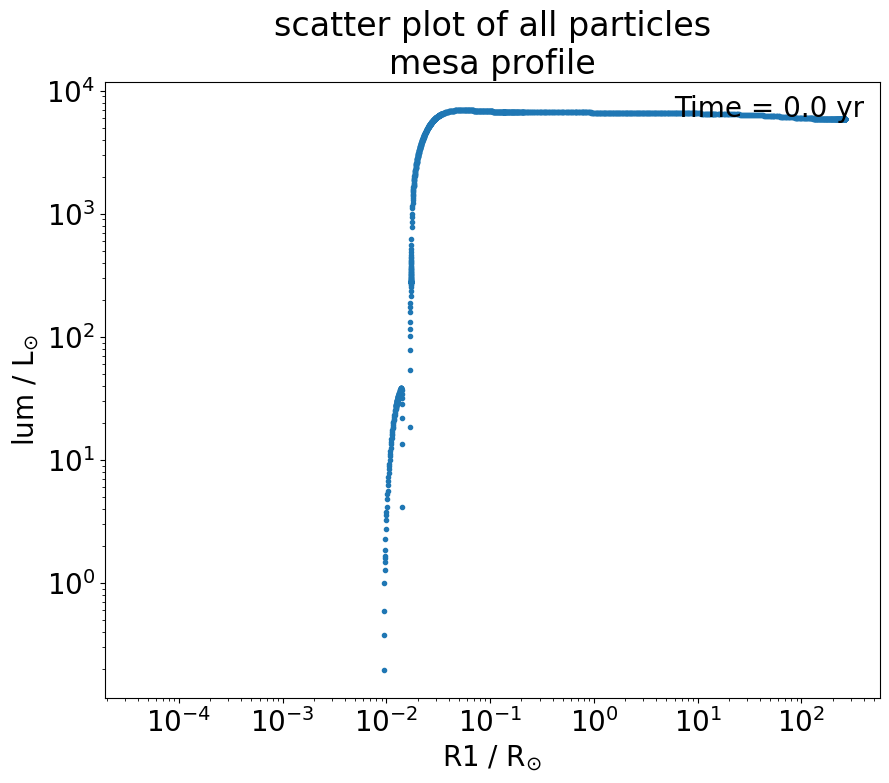

In [22]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'lum', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [23]:
stuff_mesa['T']

<Quantity [3.13480871e+03, 3.13480872e+03, 3.13480872e+03, ...,
           8.60392624e+07, 8.60381553e+07, 8.60371077e+07] K>

In [ ]:
eos_opacity.get_kappa(stuff_mesa)

In [24]:
stuff_mesa['lum'][:10]

<Quantity [5942.18103437, 5942.18103437, 5942.18103437, 5942.18103437,
           5942.18103437, 5942.18103437, 5942.18103437, 5942.18103437,
           5942.18103437, 5942.18103438] solLum>

In [22]:
stuff_mesa['L'][0], stuff_mesa['lum'][0]

(<Quantity 5963.57578799 solLum>, <Quantity 5942.18103437 solLum>)

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'T', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

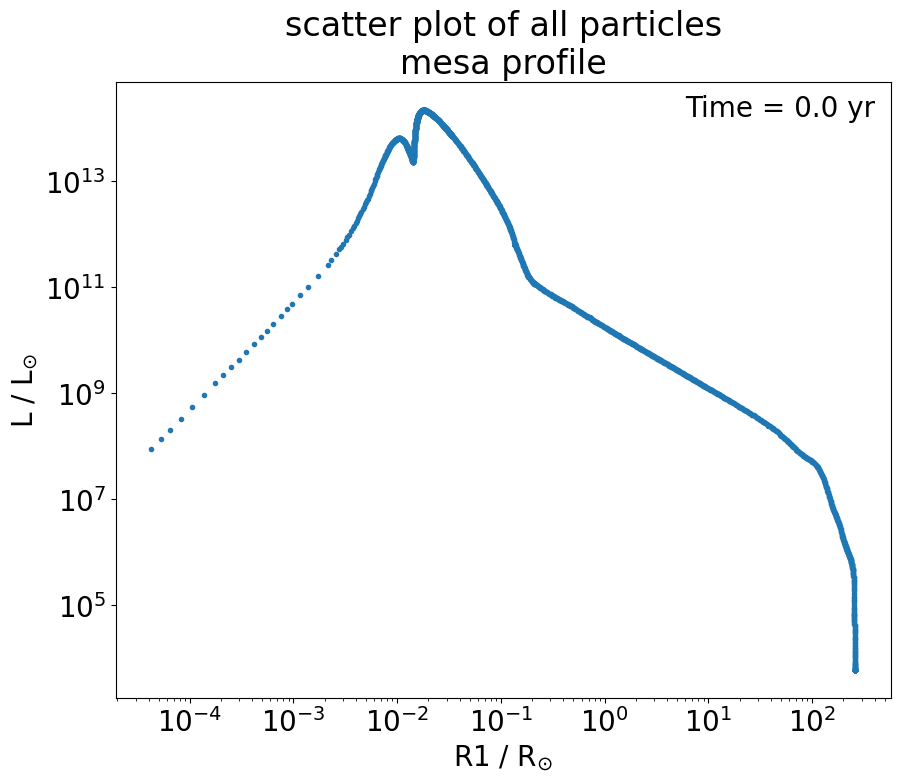

In [20]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'L', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [191]:
stuff_mesa['R1'][::100]

<Quantity [2.61808921e+02, 2.55975645e+02, 1.94075405e+02, 7.30456979e+01,
           1.04704689e+01, 2.71052753e+00, 7.73360559e-01, 1.88993556e-01,
           1.36619719e-01, 6.87743903e-02, 3.22256485e-02, 2.51569830e-02,
           2.00607213e-02, 1.71544759e-02, 1.59214561e-02, 1.47879525e-02,
           1.34108519e-02, 1.03266723e-02, 1.16591858e-03] solRad>

In [ ]:
# phantom plots

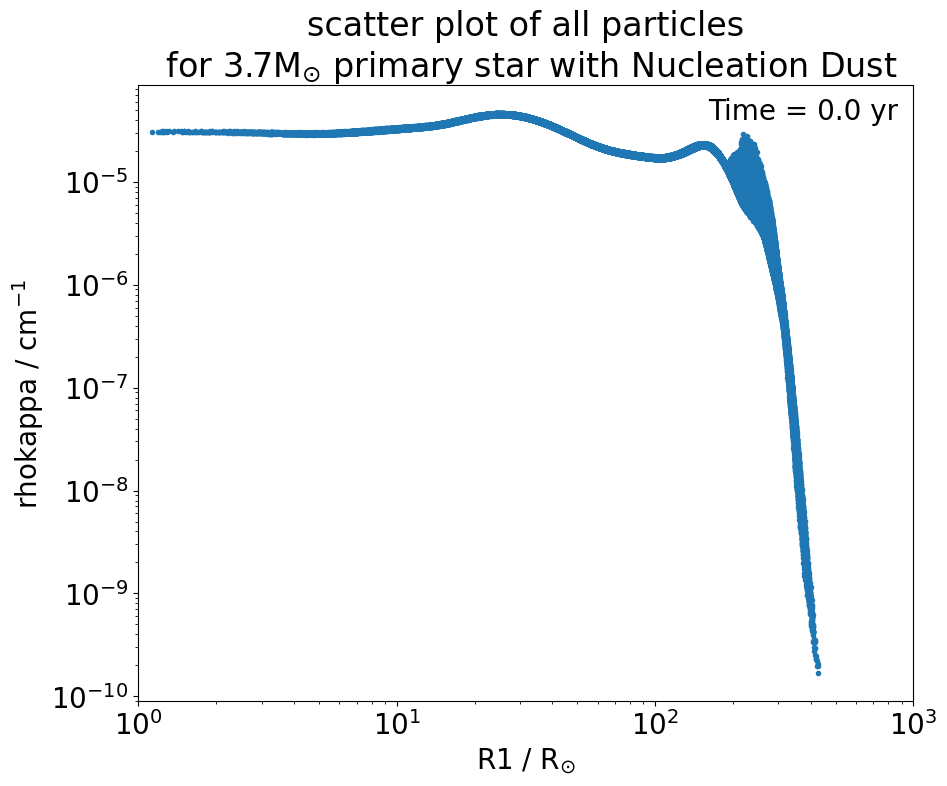

In [17]:
fig, ax = plot_stuff(stuff, 'R1', 'rhokappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

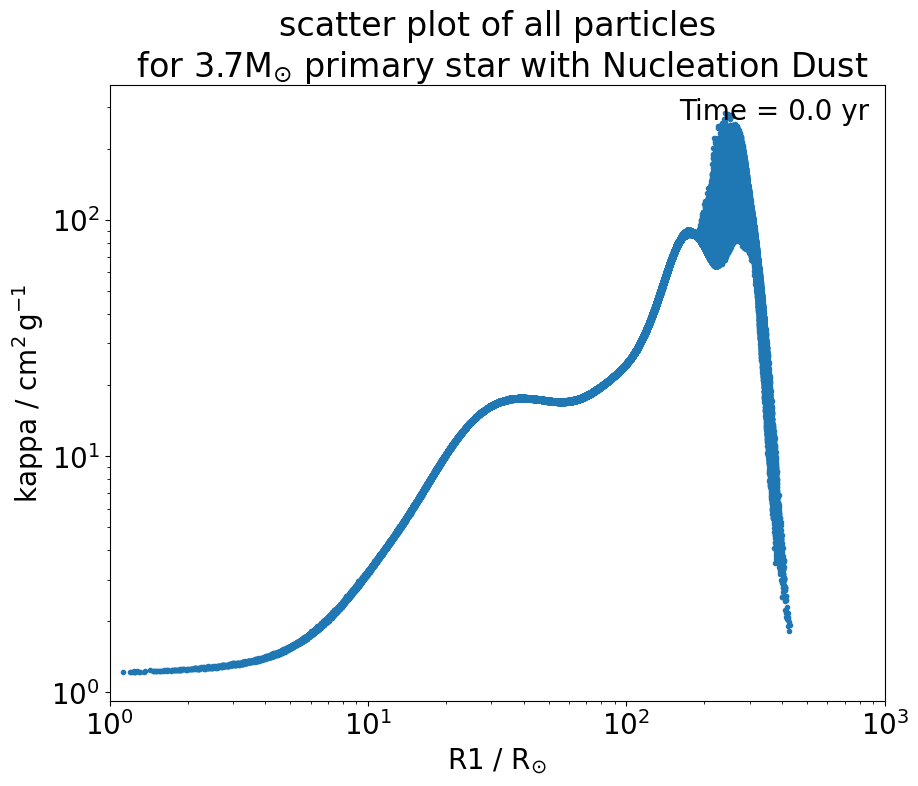

In [136]:
fig, ax = plot_stuff(stuff, 'R1', 'kappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

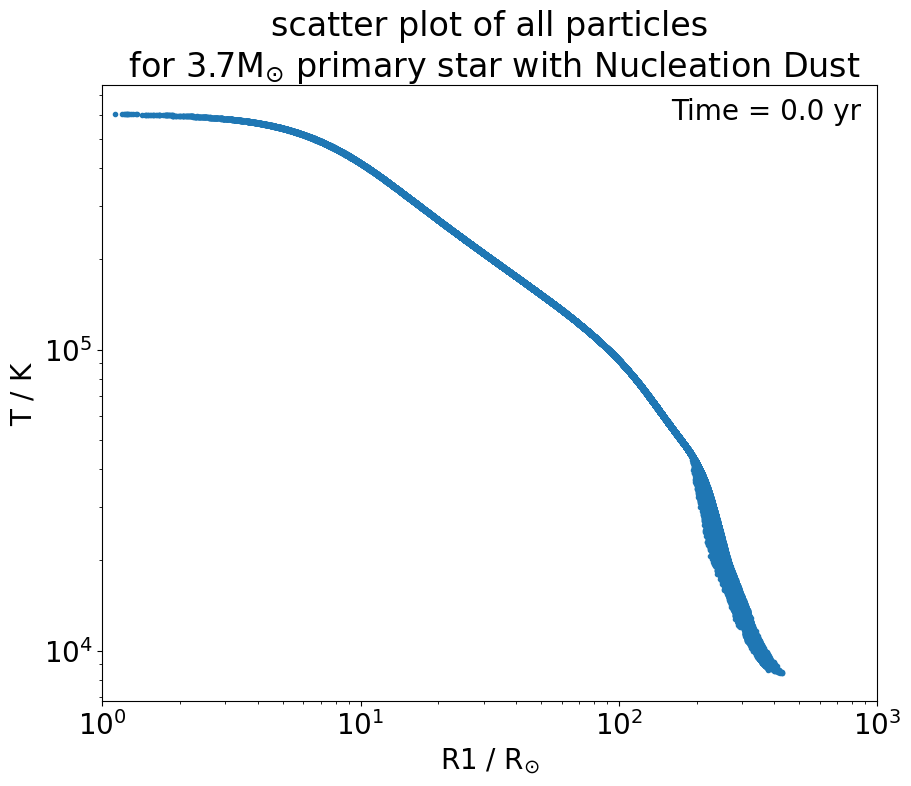

In [137]:
fig, ax = plot_stuff(stuff, 'R1', 'T', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

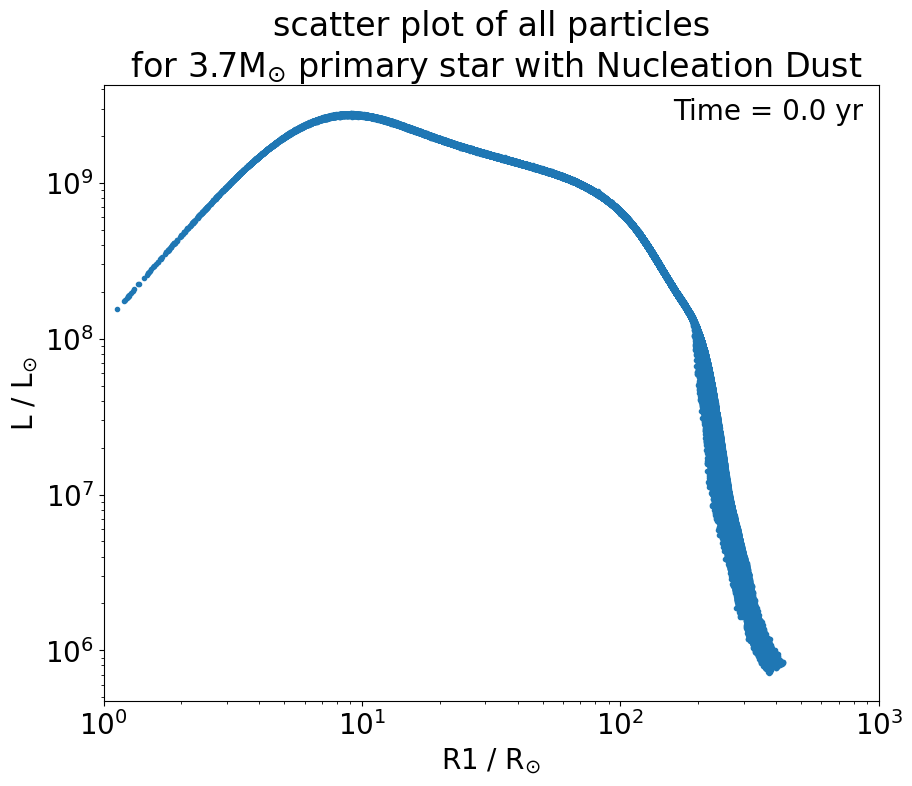

In [179]:
fig, ax = plot_stuff(stuff, 'R1', 'L', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Cross-Section at z = 0.0\nresolution = 1.37e+06'}, xlabel='x', ylabel='y'>)

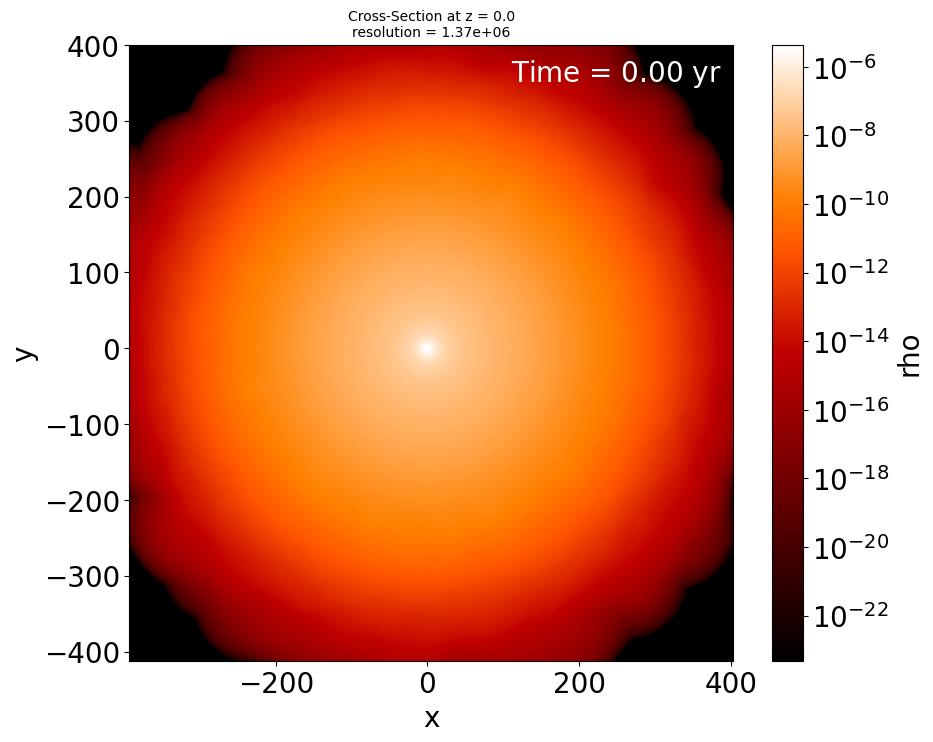

In [64]:
mpdf.plot_render()

In [76]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17), frac_contained=99.99)
rays

array([[[-377.92692617, -384.18817369,    0.        ],
        [-377.92692617, -384.18817369,    1.        ]],

       [[-330.6860604 , -384.18817369,    0.        ],
        [-330.6860604 , -384.18817369,    1.        ]],

       [[-283.44519463, -384.18817369,    0.        ],
        [-283.44519463, -384.18817369,    1.        ]],

       ...,

       [[ 283.44519463,  384.18817369,    0.        ],
        [ 283.44519463,  384.18817369,    1.        ]],

       [[ 330.6860604 ,  384.18817369,    0.        ],
        [ 330.6860604 ,  384.18817369,    1.        ]],

       [[ 377.92692617,  384.18817369,    0.        ],
        [ 377.92692617,  384.18817369,    1.        ]]])

In [86]:
no_xy=(17, 17)
rays, areas = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=99.99)
lums = []
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lums.append(dat * area) #* 4 * pi 
    if len(lums)%10 == 0:
        print(len(lums))

lums = (lums * mpdf.units['lum']).to(units.solLum)
lum = lums.sum()
lum

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


<Quantity 273543.11736144 solLum>

In [267]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity)
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T'] * sdf['T']**4 #/ (4 * pi)

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([9.36841334e-13 3.02453466e-14 2.47169186e-14])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 0.00000000e+00  3.59257537e-16 -1.80945419e-16]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])


In [242]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17))
lum = 0.
lums = []
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi
    lums.append(dat*area)
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)/1e6

0
50
100
150
200
250


<Quantity 441.35704836 solLum>

In [270]:
sdf['R0'] = (sdf['x']**2 + sdf['y']**2 + sdf['z']**2)**0.5
sdf['kappa_cgs'] = mupl.units_util.get_val_in_unit(sdf['kappa'], mpdf.units['opacity'], units.cm**2/units.g)
sdf.iloc[np.array(sdf['R0'] > 380)]

,iorig,x,y,z,temperature,gamma,vx,vy,vz,u,...,divv,poten,m,rho,v,vr,T,kappa_dust,R0,kappa_cgs
111,112,-333.503997,-196.819580,-58.476116,9564.784823,1.666667,0.002022,-0.018438,-0.002364,0.003201,...,-0.000093,-1.693614e-09,8.321285e-07,2.614854e-10,0.018698,0.007897,9564.784823,0.0,391.640549,14.434284
438,439,-345.411224,-39.160593,234.792402,6615.074278,1.666667,-0.002858,-0.019164,0.003671,0.001280,...,0.000110,-1.521432e-09,8.321285e-07,7.494553e-11,0.019720,0.006197,6615.074278,0.0,419.487709,0.090066
529,530,-440.836939,43.341735,14.205282,8963.335961,1.666667,-0.005641,-0.020930,0.005006,0.002863,...,0.000056,-1.577284e-09,8.321285e-07,1.240719e-10,0.022248,0.003725,8963.335961,0.0,443.190143,6.143182
906,907,-395.633312,-80.204010,59.915316,9112.569457,1.666667,0.007254,-0.013098,-0.003132,0.002439,...,-0.000450,-1.747112e-09,8.321285e-07,3.430497e-10,0.015297,-0.004918,9112.569457,0.0,408.103230,9.463218
1146,1147,-326.235900,-227.981242,124.129664,8781.755459,1.666667,-0.001352,-0.030919,0.006285,0.003117,...,0.000229,-1.493005e-09,8.321285e-07,6.204438e-11,0.031580,0.019836,8781.755459,0.0,416.909441,4.060100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370136,1370137,-343.056122,176.931071,-58.063187,9766.805514,1.666667,-0.002968,-0.013376,-0.003774,0.003291,...,0.000198,-1.737399e-09,8.321285e-07,3.301369e-10,0.014211,-0.002893,9766.805514,0.0,390.337598,18.601888
1370938,1370939,-397.871879,7.405970,-112.754290,9627.812530,1.666667,0.006797,-0.021440,-0.003923,0.003228,...,-0.000230,-1.703030e-09,8.321285e-07,2.787013e-10,0.022831,-0.005853,9627.812530,0.0,413.606589,15.574132
1371122,1371123,-387.733425,41.448333,-4.518698,10750.967039,1.666667,-0.004583,-0.015976,-0.002957,0.003920,...,0.000020,-1.910990e-09,8.321285e-07,8.187017e-10,0.016882,0.002893,10750.967039,0.0,389.968706,51.144606
1371170,1371171,-294.004232,-242.893745,-147.497417,6726.268402,1.666667,0.002479,-0.022371,-0.000131,0.001310,...,0.000036,-1.485059e-09,8.321285e-07,6.082245e-11,0.022508,0.011554,6726.268402,0.0,408.890386,0.107749


(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Cross-Section at z = 0.0\nresolution = 1.37e+06'}, xlabel='x', ylabel='y'>)

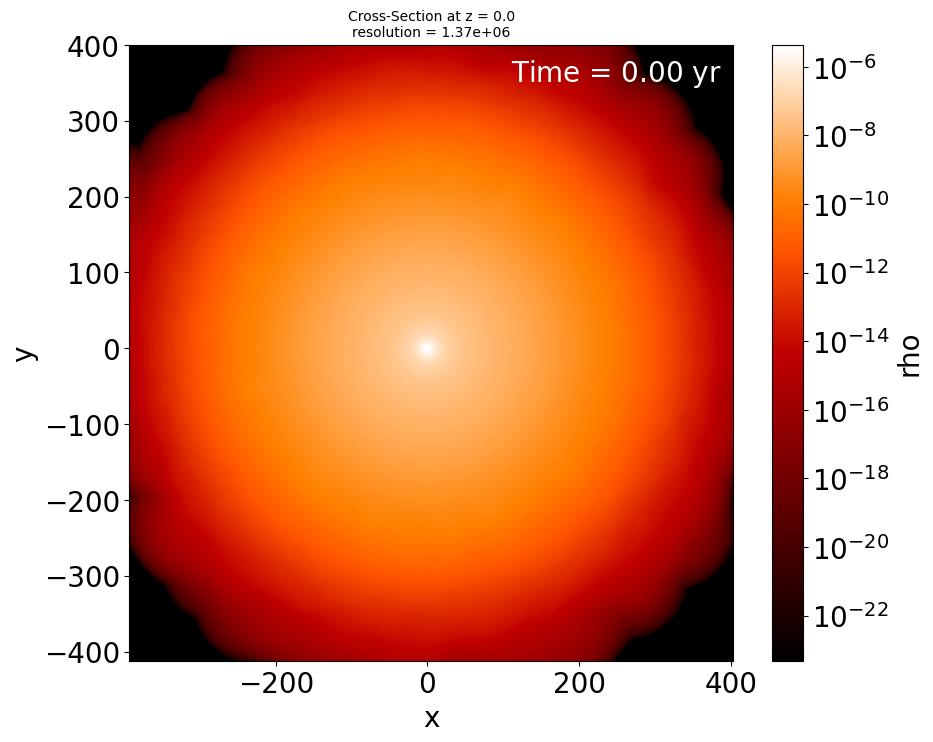

In [57]:
mpdf.plot_render()

In [244]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(16, 16))
lum = 0.
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi 
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)

0
50
100
150
200
250


<Quantity 4.43158595e+08 solLum>

In [37]:
ans = integrate_along_ray(sdf, ray, srcfuncs)
pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
dat

backward dat =  1.1572865300327659e-15
	Contribution to L from photosphere and outwards is: 31.877263611212765 %
	50% Contributed correspond to tau = 1.6343815396229042
forward dat =  1.157286530032766e-15


1.157286530032766e-15

In [43]:

np.where(dat_bwd_inc / dat > 1e-7), dat_bwd_inc.shape

((array([  0,   1,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  15,
          16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
          55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
          68,  69,  70,  71,  73,  74,  75,  77,  81,  82,  85, 308, 314,
         315, 319, 320, 322, 326, 329, 334, 335, 336, 338, 342, 343, 344,
         346, 348, 349, 350, 353, 354, 355, 356, 359, 363, 364, 365, 367,
         368, 369, 371, 373, 374, 375, 377, 381, 382, 383, 385, 387, 389,
         394, 396, 400, 401, 402, 403, 404, 405, 406, 408, 410, 412, 414,
         424, 429]),),
 (4694,))

In [7]:
def get_ph_vals(
    vals_names: list,
    mpdf: MyPhantomDataFrames,
    eos: mupl.eos_base.EoS_Base,
    rays_unit_vecs : np.ndarray, # (no_ray, 3)-shaped
    verbose: int,
):
    sdf_all = mpdf.data['gas']
    hs = np.array(sdf_all['h'])
    pts = np.array(sdf_all[['x', 'y', 'z']])    # (npart, 3)-shaped array
    kernel_radius = sdf_all.kernel.get_radius()

    plane_orig_vec = np.array(mpdf.data['sink'][['x', 'y', 'z']].iloc[0])

    # random direction in the sphere
    #rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
    no_ray = len(rays_unit_vecs)
    
    vals_dict = {
        'tau_dust': np.full(no_ray, np.nan),
        'inner_dust_shell_rad': np.full(no_ray, np.nan) * mpdf.units['dist'],
    }
    
    for iray, ray_unit_vec in enumerate(rays_unit_vecs):
        ray = np.array([
            plane_orig_vec,
            plane_orig_vec + ray_unit_vec,
        ])
        
        pts_on_ray = mupl.get_closest_pt_on_line(pts, ray)
        sdf_selected_indices = (np.sum((pts - pts_on_ray)**2, axis=-1) <= (kernel_radius * hs)**2)
        sdf = sdf_all.iloc[sdf_selected_indices]
        
        pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf, ray)
        photosphere, waypts_list = get_photosphere_on_ray(
            pts_on_ray, dtaus, pts_order, sdf, ray,
            calc_params = vals_names,
            eos = eos,
            sdf_units = mpdf.units,
            photosphere_tau = PHOTOSPHERE_TAU,
            return_as_quantity=True,
            verbose = 1 if is_verbose(verbose, 'err') else 0,
        )
        for val_name in vals_names:
            if iray == 0:
                # init
                vals_dict[val_name] = np.full((*photosphere[val_name].shape, no_ray), np.nan)
                if isinstance(photosphere[val_name], units.quantity.Quantity):
                    vals_dict[val_name] *= photosphere[val_name].unit
            # save value
            vals_dict[val_name][iray] = photosphere[val_name]
            
            kappa_tol = 1e-7*(units.cm**2/units.g)
            kappa_tol_val = kappa_tol.to_value(mpdf.units['opacity'])
            pts_waypts_t = np.sum((pts_on_ray - ray[0]) * ray_unit_vec, axis=-1) # the higher, the more on the pt2 side (observer)
            # find the furtherest dust-containing particle on the observer's side
            last_dust_part_ordered_indices = np.where(np.logical_and(
                pts_waypts_t[pts_order] > 0,    # condition 1: on the observer's side (i.e. don't be further than the sink)
                sdf.iloc[pts_order]['kappa_dust'] > kappa_tol_val,    # condition 2: dust-containing
            ))[0]
            if len(last_dust_part_ordered_indices):
                # found the dust shell!
                last_dust_part_ordered_ind = last_dust_part_ordered_indices[-1]
                vals_dict['tau_dust'][iray] = np.sum(dtaus[pts_order][:last_dust_part_ordered_ind])
                vals_dict['inner_dust_shell_rad'][iray] = mupl.set_as_quantity(
                    pts_waypts_t[pts_order][last_dust_part_ordered_ind], mpdf.units['dist'])
    vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
    vals_dict['ray_unit_vec'] = rays_unit_vecs
    
    return vals_dict

In [8]:
def get_photosphere_vals_rand_samples(
    job_nickname: str,
    file_index: int,
    no_ray: int,
    vals_names: list = ['R1', 'T'],
    cos_theta_sample_no: int|None = None,
    mpdf: MyPhantomDataFrames = None,
    verbose: int = 3,
) -> dict:
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    ieos = job_profile['ieos']
    eos  = get_eos(ieos, params, settings)
    eos_opacity = EoS_MESA_opacity(params, settings)
    
    mpdf = mpdf_read(
        job_name, file_index, eos_opacity, mpdf,
        kappa_gas = 2e-4*(units.cm**2/units.g) if file_index != 0 else 0.*(units.cm**2/units.g),
        verbose=verbose)

    if cos_theta_sample_no is None:

        rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
        vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
    
        if is_verbose(verbose, 'note'):
            say('note', f'{mpdf.get_filename()}', verbose,
                *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
            )
    else:
        # A fixed amount of rays per cos_theta interval will be generated
        #cos_theta_sample_no = 2
        ray_per_cos_theta = int(no_ray/cos_theta_sample_no)
        cos_theta_delta = 1. / cos_theta_sample_no
        cos_thetas = np.linspace(-1+cos_theta_delta, 1-cos_theta_delta, cos_theta_sample_no)
        vals_by_cos_thetas = []
    
        for i, cos_theta_mid in enumerate(cos_thetas):
            rays_unit_vecs = get_rand_rays_unit_vec(ray_per_cos_theta, cos_theta_mid, cos_theta_delta)
            vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
            #vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
            vals_by_cos_thetas.append(vals_dict)
        
            if is_verbose(verbose, 'note'):
                say('note', f'cos_theta_mid = {cos_theta_mid}', verbose,
                    *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
                )
        
        vals_dict = { key: np.concatenate([data[key] for data in vals_by_cos_thetas]) for key in vals_by_cos_thetas[0].keys()}

    return vals_dict

.

# Main

.


In [10]:
if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    for job_nickname in ['2md']:  # '2md', 
        for file_index in [4800, 6400]: # [0, 2000, 8000, 17600]
            vals_dict = get_photosphere_vals_rand_samples(
                job_nickname, file_index, no_ray, vals_names=['R1', 'T', 'rho', 'kappa', 'nneigh', 'vr'], cos_theta_sample_no=None, mpdf=mpdf)
            with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'w') as f:
                json_dump(vals_dict, f, metadata)
    if is_verbose(verbose, 'note'):
        say('note', '__main__', verbose, f"\n\n\n*** All Done. ***\n\n\n")

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_04800'


*   Note   :    MyPhantomDataFrames.read():
	CoM significantly deviates from the origin with distance of 3.720647492094738.
	Consider use reset_xyz_by_CoM=True option when read?
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
91705 1356310
*   Note   :    ../photosphere/luis_2md/light_04800:
	R1 = 27094.61603459788 udist +/- 1954.4331316030925 udist
	T = 513.0249707436063 K +/- 50.96035232156766 K
	rho = 1.7947891556866646e-16 umass / udist3 +/- 4.520868390693096e-17 umass / udist3
	kappa = 2554526279067.905 